In [1]:
import sys
sys.path.append("..")
import shap
import xgboost
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import train_test_split

In [2]:
shap.initjs()

In [3]:
# train XGBoost model
X,y = shap.datasets.boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [4]:
X_instanced = pd.concat((X,pd.DataFrame(columns = ['instance'])),axis = 1)
X_instanced['instance'].loc[X_train.index] = 'train'
X_instanced['instance'].loc[X_test.index] = 'test'
y_instanced = pd.concat((pd.DataFrame(y),pd.DataFrame(columns = ['instance'])),axis = 1)
y_instanced['instance'].loc[X_train.index] = 'train'
y_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [6]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [7]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

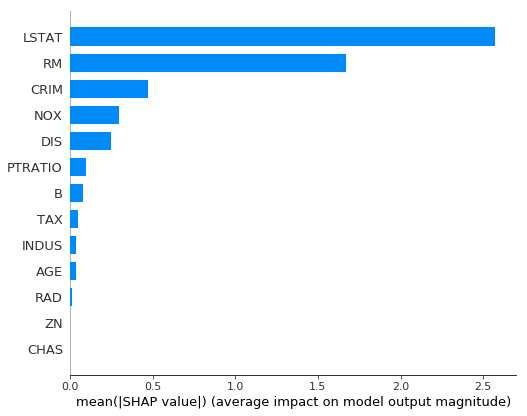

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X,plot_type = 'bar')

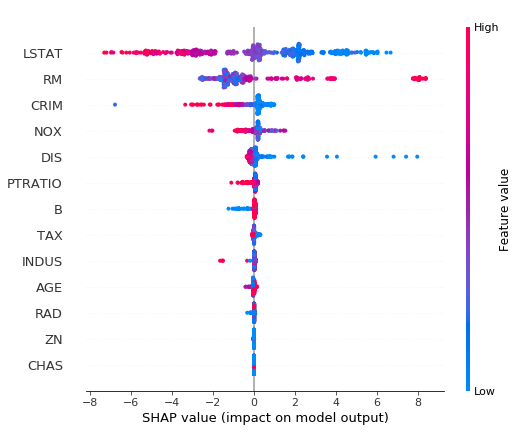

In [9]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [10]:
#Gather shapley values and output values in one dataframe
shap_dataframe = pd.DataFrame(data = shap_values,columns = X.columns)
output_dataframe = pd.DataFrame(data = y,columns = ['house_values'])
shap_dataframe = pd.concat([shap_dataframe,output_dataframe],axis = 1)

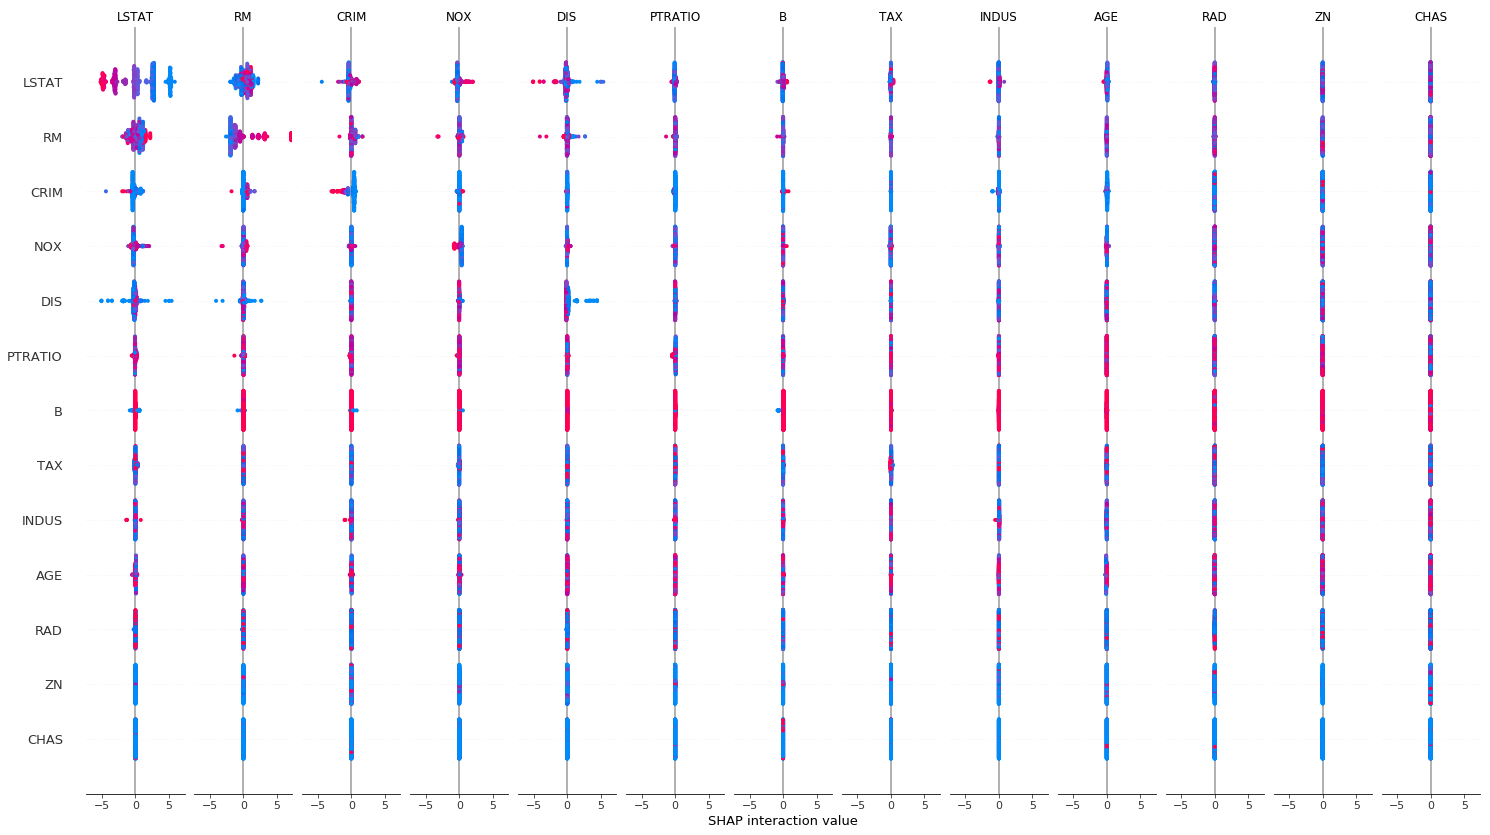

In [11]:
#Make interaction plot for all features
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X, max_display = len(shap_dataframe.columns)-1)

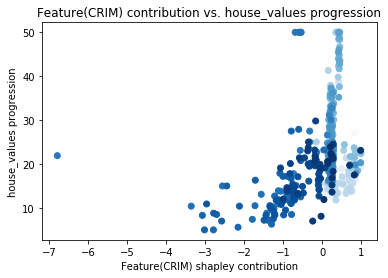

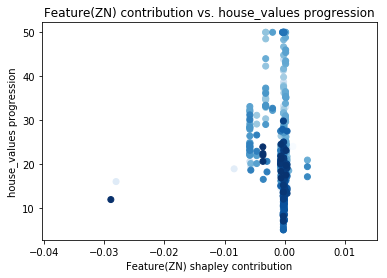

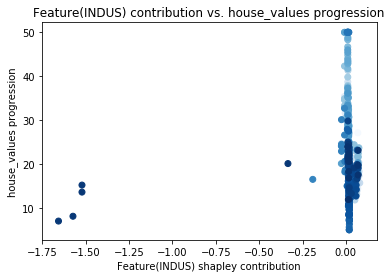

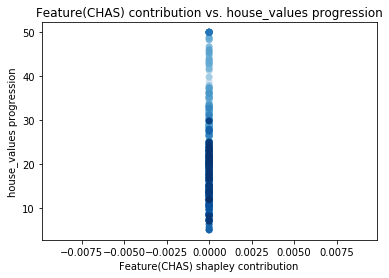

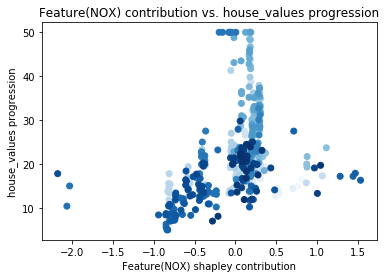

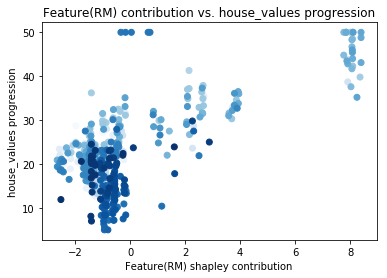

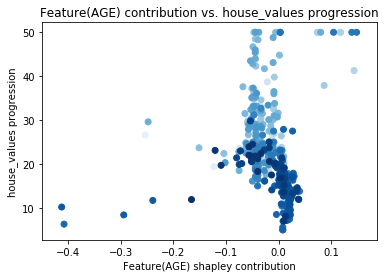

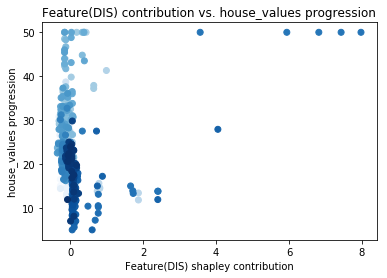

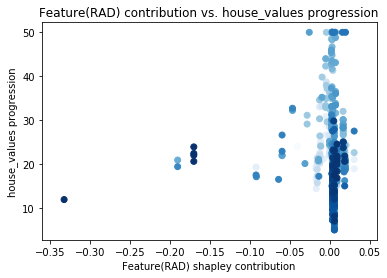

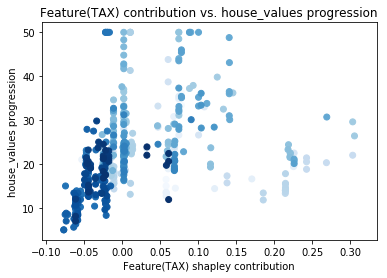

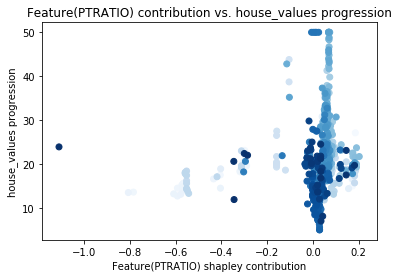

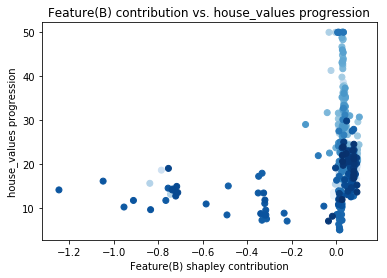

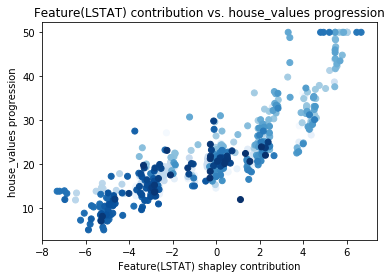

In [12]:
from Framework import plotHelper
plotHelper.plotAllFeatures(shap_dataframe)

In [13]:
#Start clustering
from Framework import cluster
from sklearn.cluster import KMeans
nClusters = 3
#Train KMeans, because the data is unsupervised(Regression data)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,shap_values)

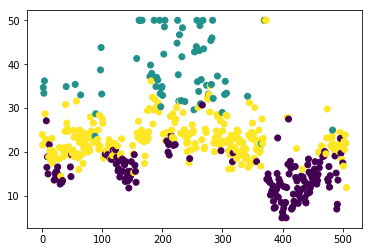

In [14]:
#Get the labels, concat into original data, and sor the labels for into cluster groups
shap_dataframe_labeled = pd.concat([shap_dataframe,pd.DataFrame(kmeans.labels_,columns =[ 'labels'])],axis = 1)
#shap_grouped = shap_dataframe_labeled.sort_values(['labels'])
X_labeled = pd.concat([X,shap_dataframe_labeled['labels']], axis = 1)
plt.scatter(np.linspace(0,len(X),len(X)),y,c = X_labeled['labels'])

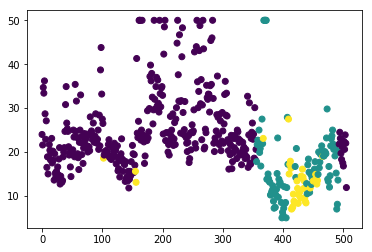

In [15]:
kmeans_original = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,X)
plt.scatter(np.arange(len(X)),y,c = kmeans_original.labels_)

In [16]:
#Split the clusters into a dictionary
data_dict = cluster.splitDataLabeled(nClusters,shap_dataframe,shap_dataframe_labeled['labels'])
data_dict_original = cluster.splitDataLabeled(nClusters,X,kmeans_original.labels_)

In [17]:
original_split = cluster.convertOriginalData(data_dict_original,X_instanced,y_instanced)
original_split_shapley = cluster.convertOriginalData(data_dict,X_instanced,y_instanced)

In [18]:
original_split

{'original_data_cluster0':         CRIM    ZN  INDUS  CHAS    NOX     RM    AGE      DIS  RAD    TAX  \
 0    0.00632  18.0   2.31   0.0  0.538  6.575   65.2   4.0900  1.0  296.0   
 1    0.02731   0.0   7.07   0.0  0.469  6.421   78.9   4.9671  2.0  242.0   
 2    0.02729   0.0   7.07   0.0  0.469  7.185   61.1   4.9671  2.0  242.0   
 3    0.03237   0.0   2.18   0.0  0.458  6.998   45.8   6.0622  3.0  222.0   
 4    0.06905   0.0   2.18   0.0  0.458  7.147   54.2   6.0622  3.0  222.0   
 5    0.02985   0.0   2.18   0.0  0.458  6.430   58.7   6.0622  3.0  222.0   
 6    0.08829  12.5   7.87   0.0  0.524  6.012   66.6   5.5605  5.0  311.0   
 7    0.14455  12.5   7.87   0.0  0.524  6.172   96.1   5.9505  5.0  311.0   
 8    0.21124  12.5   7.87   0.0  0.524  5.631  100.0   6.0821  5.0  311.0   
 9    0.17004  12.5   7.87   0.0  0.524  6.004   85.9   6.5921  5.0  311.0   
 10   0.22489  12.5   7.87   0.0  0.524  6.377   94.3   6.3467  5.0  311.0   
 11   0.11747  12.5   7.87   0.0  0.52

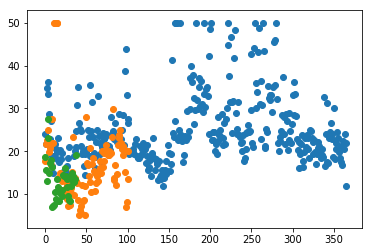

In [19]:
#Scatter the groups again...
#plt.scatter(np.linspace(-1,1,len(original_label_cluster2)),cluster2_predictions)
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster1'])),original_split['original_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split['original_label_cluster2'])),original_split['original_label_cluster2'].iloc[:,0])

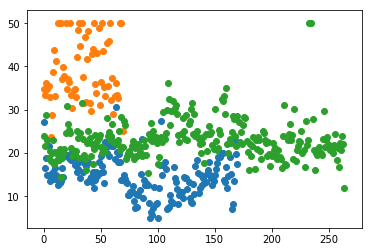

In [20]:
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster0'])),original_split_shapley['original_label_cluster0'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster1'])),original_split_shapley['original_label_cluster1'].iloc[:,0])
plt.scatter(np.arange(len(original_split_shapley['original_label_cluster2'])),original_split_shapley['original_label_cluster2'].iloc[:,0])

In [21]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}

eval_results = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}

model_dict,eval_results = cluster.trainMultipleModels(xgboost.train,original_split,'XGBoost',params,**kwargs)
#small_model_1 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_2 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_3 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:8.52119	test-rmse:7.93445
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[595]	train-rmse:1.76122	test-rmse:2.72669

[0]	train-rmse:9.83453	test-rmse:11.853
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[299]	train-rmse:1.66603	test-rmse:8.55687

[0]	train-rmse:10.6746	test-rmse:7.80186
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:0.200354	test-rmse:3.85055
Stopping. Best iteration:
[857]	train-rmse:0.253969	test-rmse:3.83225



In [22]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shapley = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_shapley,eval_results_shapley = cluster.trainMultipleModels(xgboost.train,original_split_shapley,'XGBoost',params,**kwargs)
#small_model_shapley1 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_shapley2 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_shapley3 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:8.6652	test-rmse:8.15708
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[517]	train-rmse:1.43344	test-rmse:3.81601

[0]	train-rmse:17.0693	test-rmse:19.2452
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[132]	train-rmse:3.26239	test-rmse:4.08091

[0]	train-rmse:4.26642	test-rmse:6.25482
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[504]	train-rmse:1.56951	test-rmse:4.01908



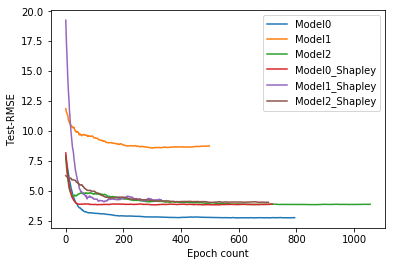

In [23]:
plt.plot(np.arange(len(eval_results['eval0']['test']['rmse'])),eval_results['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['test']['rmse'])),eval_results['eval2']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['test']['rmse'])),eval_results_shapley['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['test']['rmse'])),eval_results_shapley['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['test']['rmse'])),eval_results_shapley['eval2']['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

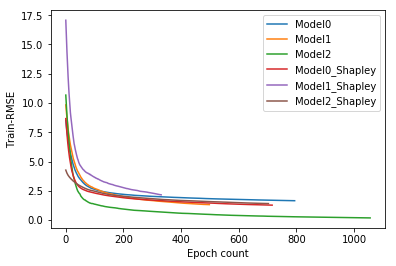

In [24]:
plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['train']['rmse'])),eval_results_shapley['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['train']['rmse'])),eval_results_shapley['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['train']['rmse'])),eval_results_shapley['eval2']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])

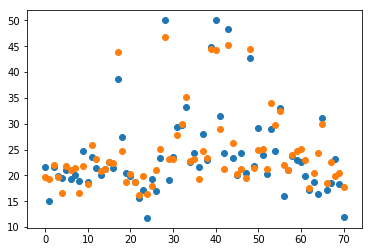

In [25]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),original_split['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),model_dict['model0'].predict(xgboost.DMatrix(original_split['original_test_cluster0'])))

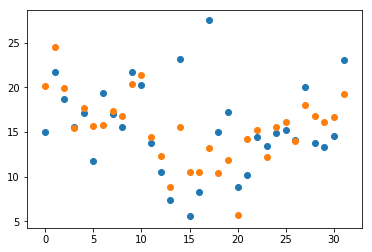

In [26]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),model_dict_shapley['model0'].predict(xgboost.DMatrix(original_split_shapley['original_test_cluster0'])))

In [27]:
#Train overall model
ev_result = {}
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse",
}
model = xgboost.train(params,xgboost.DMatrix(X_train, label=y_train),10000,evals = [(xgboost.DMatrix(X_train, label=y_train), "train"),(xgboost.DMatrix(X_test, label=y_test), "test")] ,verbose_eval = 1000,evals_result = ev_result,early_stopping_rounds = 200)
tot_result_big_model = min(ev_result['test']['rmse'])

[0]	train-rmse:9.0156	test-rmse:8.86713
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[182]	train-rmse:3.08349	test-rmse:5.0093



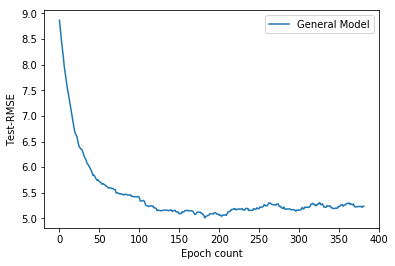

In [28]:
plt.plot(np.arange(len(ev_result['test']['rmse'])),ev_result['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['General Model'])

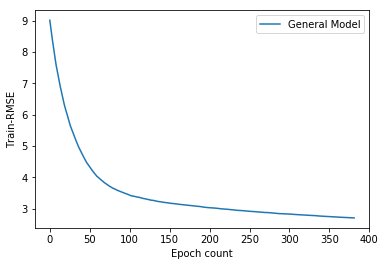

In [29]:
plt.plot(np.arange(len(ev_result['train']['rmse'])),ev_result['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['General Model'])

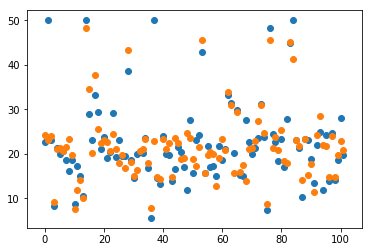

In [30]:
plt.scatter(np.arange(len(X_test)),y_test)
plt.scatter(np.arange(len(X_test)),model.predict(xgboost.DMatrix(X_test)))

In [31]:
#Evaluation of results
from Framework import metrics
sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split_shapley['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shapley['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap = metrics.ensembleRMSE(sizes,rmse_array)

In [32]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca = PCA(n_components=nPcaComponents)
shap_values_pca = pca.fit_transform(shap_values)
print(pca.explained_variance_ratio_.sum())

0.9294517


In [33]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca_org = PCA(n_components=nPcaComponents)
org_values_pca = pca_org.fit_transform(X)
print(pca_org.explained_variance_ratio_.sum())

0.9688751429772718


Text(0, 0.5, 'Second principal component')

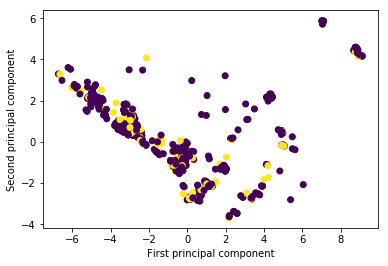

In [34]:
#PCA Clusters are quite seperate,could be used in clustering
label_colors = [ 0 if a == 'train' else 1 for a in X_instanced['instance']]
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = label_colors)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
#Add to labels to the scatter plot (Colors)
#How do we interpret this ?

In [35]:
kmeans_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,shap_values_pca)
kmeans_org_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,org_values_pca)

Text(0, 0.5, 'Second principal component')

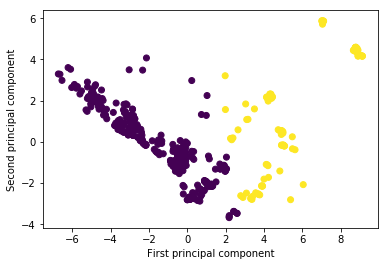

In [36]:
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = kmeans_pca.labels_)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [45]:
data_dict_shap_pca = cluster.splitDataLabeled(2,shap_values_pca,kmeans_pca.labels_)
data_dict_org_pca = cluster.splitDataLabeled(2,org_values_pca,kmeans_org_pca.labels_)
data_dict_org_pca

{'cluster0':               0          1
 0   -119.818843  -5.560056
 1   -168.890155  10.116209
 2   -169.311707  14.080532
 3   -190.230642  18.302463
 4   -190.133451  16.097947
 5   -188.950577  18.729163
 6   -104.335997  -8.735509
 7   -102.094308 -10.108030
 8    -98.528271  -0.247909
 9   -100.030155  -0.317668
 10  -100.939971  -5.901410
 11  -103.335594 -10.066547
 12  -105.082791  -3.682179
 13  -108.449123  -8.824296
 14  -101.587305   7.197688
 15  -108.513367  -7.568976
 16  -108.265198   0.964360
 17  -103.674453   0.804914
 18   -79.040983  94.521786
 19  -105.994054  -3.161430
 20   -99.175359  10.484407
 21  -104.746088  -4.769217
 22  -105.686265  -8.931241
 23  -104.285758  -6.717167
 24  -104.809282  -6.504693
 25   -79.029647  80.471463
 26  -100.083531  10.193346
 27   -79.611863  77.628801
 28  -103.003970  -0.416222
 29  -101.363358   6.993350
 ..          ...        ...
 339 -188.675904  15.552035
 340 -187.590417  15.474513
 341 -132.687034   0.132820
 342    

In [38]:
pca_instanced = pd.concat((pd.DataFrame(org_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
pca_instanced['instance'].loc[X_train.index] = 'train'
pca_instanced['instance'].loc[X_test.index] = 'test'
shap_pca_instanced = pd.concat((pd.DataFrame(shap_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
shap_pca_instanced['instance'].loc[X_train.index] = 'train'
shap_pca_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
original_shap_pca = cluster.convertOriginalData(data_dict_shap_pca,shap_pca_instanced,y_instanced)
original_pca = cluster.convertOriginalData(data_dict_org_pca,pca_instanced,y_instanced)

In [40]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_org_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_org_pca,eval_results_org_pca = cluster.trainMultipleModels(xgboost.train,original_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:8.67004	test-rmse:8.10015
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[220]	train-rmse:6.70243	test-rmse:7.82444

[0]	train-rmse:10.0843	test-rmse:10.907
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[97]	train-rmse:6.63512	test-rmse:9.86757



In [41]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shap_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
model_dict_shap_pca,eval_results_shap_pca = cluster.trainMultipleModels(xgboost.train,original_shap_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:6.20359	test-rmse:5.64768
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[255]	train-rmse:2.36701	test-rmse:2.661

[0]	train-rmse:15.1896	test-rmse:17.6832
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:1.79638	test-rmse:5.22175
[2000]	train-rmse:1.27625	test-rmse:4.87301
Stopping. Best iteration:
[2493]	train-rmse:1.09843	test-rmse:4.73592



In [42]:
sizes = []
rmse_array = []
for i in range(nPcaComponents):
    sizes.append(len(original_shap_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shap_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap_pca = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(2):
    sizes.append(len(original_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_org_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org_pca = metrics.ensembleRMSE(sizes,rmse_array)

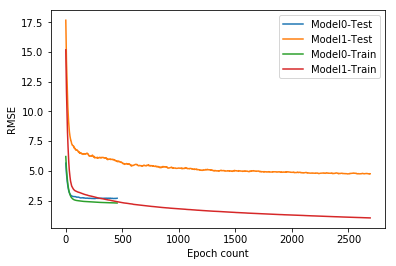

In [43]:
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['test']['rmse'])),eval_results_shap_pca['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['test']['rmse'])),eval_results_shap_pca['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['train']['rmse'])),eval_results_shap_pca['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['train']['rmse'])),eval_results_shap_pca['eval1']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('RMSE')
plt.legend(['Model0-Test','Model1-Test','Model0-Train','Model1-Train'])

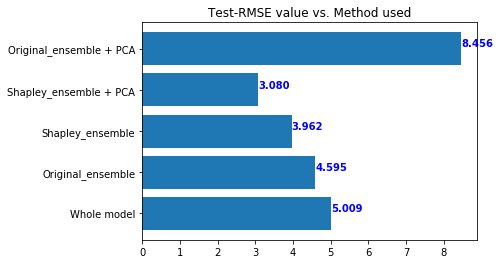

In [44]:
ax = plt.figure()
plt.barh(['Whole model','Original_ensemble','Shapley_ensemble','Shapley_ensemble + PCA','Original_ensemble + PCA'],[tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca])
plt.title('Test-RMSE value vs. Method used')
for i,v in enumerate([tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca]):
    plt.text(v , i + .05, '{0:.3f}'.format(v), color='blue', fontweight='bold')

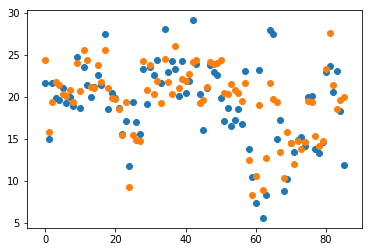

In [49]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_shap_pca['original_test_label_cluster0'])),original_shap_pca['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_shap_pca['original_test_label_cluster0'])),model_dict_shap_pca['model0'].predict(xgboost.DMatrix(original_shap_pca['original_test_cluster0'])))

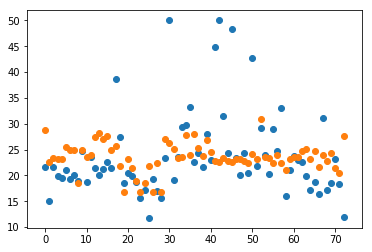

In [50]:
plt.scatter(np.arange(len(original_pca['original_test_label_cluster0'])),original_pca['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_pca['original_test_label_cluster0'])),model_dict_org_pca['model0'].predict(xgboost.DMatrix(original_pca['original_test_cluster0'])))